# Predictive Modeling of Housing Prices in Philadelphia


## Part 1: Modeling Philadelphia's Housing Prices and Algorithmic Fairness


### 1.1 Load data from the Office of Property Assessment

Use `carto2gpd` to load data for **single-family** properties in Philadelphia that had their **last sale during 2019**.

Sources: 
- [OpenDataPhilly](https://www.opendataphilly.org/dataset/opa-property-assessments)
- [Metadata](http://metadata.phila.gov/#home/datasetdetails/5543865f20583086178c4ee5/representationdetails/55d624fdad35c7e854cb21a4/)

In [106]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import hvplot.pandas
import esri2gpd
import carto2gpd
import seaborn as sns

np.random.seed(42)

%matplotlib inline

In [107]:
# the CARTO API url
carto_url = "https://phl.carto.com/api/v2/sql"

# The table name
table_name = "opa_properties_public"

# Only pull 2019 sales for single family residential properties
where = "sale_date >= '2019-01-01' AND sale_date < '2020-01-01'" 
where = where + " AND category_code_description = 'Single Family'"

# Run the query
salesRaw = carto2gpd.get(carto_url, table_name, where=where)

# Optional: put it a reproducible order for test/training splits later
salesRaw = salesRaw.sort_values("parcel_number")

In [108]:
salesRaw

,geometry,cartodb_id,assessment_date,basements,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,...,unfinished,unit,utility,view_type,year_built,year_built_estimate,zip_code,zoning,pwd_parcel_id,objectid
1,POINT (-75.14854 39.93144),21,None,0,"54'7"" E OF AMERICAN",3547465,R30,ROW B/GAR 2 STY MASONRY,1,Single Family,...,None,None,None,I,1960,Y,19147,RSA5,None,2326409
2,POINT (-75.14721 39.93033),65,None,C,"40'4 1/2"" W HOWARD ST",3517081,O50,ROW 3 STY MASONRY,1,Single Family,...,None,None,None,I,1920,Y,19147,RSA5,None,2326464
0,POINT (-75.14927 39.93033),7,None,D,"182'11"" W PHILIP",3527524,O50,ROW 3 STY MASONRY,1,Single Family,...,None,None,None,I,1920,None,19147,RSA5,None,2326453
4,POINT (-75.14876 39.93011),130,None,A,28 FT W PHILIP,3534307,O30,ROW 2 STY MASONRY,1,Single Family,...,None,None,None,I,1920,Y,19147,RSA5,None,2326529
5,POINT (-75.14886 39.93012),132,None,C,56 FT W PHILIP,3465875,O30,ROW 2 STY MASONRY,1,Single Family,...,None,None,None,I,1920,Y,19147,RSA5,None,2326531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25531,POINT (-75.17638 39.95050),577247,None,None,112' W FROM 21ST ST,3472036,591,RES CONDO 5+ STY MAS+OTH,1,Single Family,...,None,PH,A,A,2018,None,19103,RMX3,None,2907669
25532,POINT (-75.17638 39.95050),577249,None,None,112' W FROM 21ST ST,3503612,5R,CONDO PARKING SPACE,1,Single Family,...,None,P202,A,I,2018,None,19103,RMX3,None,2907671
25102,POINT (-75.17638 39.95050),577255,None,None,112' W FROM 21ST ST,3497974,5R,CONDO PARKING SPACE,1,Single Family,...,None,P302,A,I,2018,None,19103,RMX3,None,2907677
25110,POINT (-75.17638 39.95050),577362,None,None,112' W FROM 21ST ST,3472036,5R,CONDO PARKING SPACE,1,Single Family,...,None,PPH1,A,I,2018,None,19103,RMX3,None,2907678


### 1.2 Load data for census tracts and neighborhoods

Load various Philadelphia-based regions we will use in our analysis.

- Census tracts can be downloaded from: http://data.phl.opendata.arcgis.com/datasets/8bc0786524a4486bb3cf0f9862ad0fbf_0.geojson
- Neighborhoods can be downloaded from:
https://raw.githubusercontent.com/azavea/geo-data/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.geojson


In [109]:
import requests

In [110]:
# API endpoint
API_endpoint = " http://data.phl.opendata.arcgis.com/datasets/8bc0786524a4486bb3cf0f9862ad0fbf_0.geojson"

# Get the JSON
census_tracts = requests.get(API_endpoint).json()

# Convert to a GeoDataFrame
census_tracts = gpd.GeoDataFrame.from_features(census_tracts, crs="EPSG:4326")

In [111]:
census_tracts

,geometry,OBJECTID,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,LOGRECNO
0,"POLYGON ((-75.22927 39.96054, -75.22865 39.960...",1,42,101,009400,42101009400,94,Census Tract 94,G5020,S,366717,0,+39.9632709,-075.2322437,10429
1,"POLYGON ((-75.23536 39.96852, -75.23545 39.969...",2,42,101,009500,42101009500,95,Census Tract 95,G5020,S,319070,0,+39.9658709,-075.2379140,10430
2,"POLYGON ((-75.24343 39.96230, -75.24339 39.962...",3,42,101,009600,42101009600,96,Census Tract 96,G5020,S,405273,0,+39.9655396,-075.2435075,10431
3,"POLYGON ((-75.17341 39.97779, -75.17386 39.977...",4,42,101,013800,42101013800,138,Census Tract 138,G5020,S,341256,0,+39.9764504,-075.1771771,10468
4,"POLYGON ((-75.17313 39.97776, -75.17321 39.977...",5,42,101,013900,42101013900,139,Census Tract 139,G5020,S,562934,0,+39.9750563,-075.1711846,10469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,"POLYGON ((-75.17135 39.91678, -75.17143 39.916...",380,42,101,037200,42101037200,372,Census Tract 372,G5020,S,1028984,0,+39.9129487,-075.1599379,10690
380,"POLYGON ((-75.11627 40.01743, -75.11660 40.017...",381,42,101,038300,42101038300,383,Census Tract 383,G5020,S,3064496,0,+40.0108630,-075.1248984,10700
381,"POLYGON ((-75.08824 40.04034, -75.08820 40.040...",382,42,101,039000,42101039000,390,Census Tract 390,G5020,S,2032689,0,+40.0357300,-075.0938840,10707
382,"POLYGON ((-75.11051 39.96952, -75.10676 39.970...",383,42,101,037800,42101037800,378,Census Tract 378,G5020,S,3760084,1936838,+39.9805802,-075.0956845,10695


In [112]:
# API endpoint
API_endpoint = "https://raw.githubusercontent.com/azavea/geo-data/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.geojson"

# Get the JSON
neighbourhoods = requests.get(API_endpoint).json()

# Convert to a GeoDataFrame
neighbourhoods = gpd.GeoDataFrame.from_features(neighbourhoods, crs="EPSG:4326")

In [113]:
neighbourhoods.head()

,geometry,name,listname,mapname,shape_leng,shape_area,cartodb_id,created_at,updated_at
0,"MULTIPOLYGON (((-75.05645 40.08743, -75.05667 ...",PENNYPACK_PARK,Pennypack Park,Pennypack Park,87084.285589,6.014076e+07,9,2013-03-19T17:41:50.508Z,2013-03-19T17:41:50.743Z
1,"MULTIPOLYGON (((-75.22719 39.97740, -75.22984 ...",OVERBROOK,Overbrook,Overbrook,57004.924607,7.692499e+07,138,2013-03-19T17:41:50.508Z,2013-03-19T17:41:50.743Z
2,"MULTIPOLYGON (((-75.16208 40.02829, -75.16145 ...",GERMANTOWN_SOUTHWEST,"Germantown, Southwest",Southwest Germantown,14880.743608,1.441867e+07,59,2013-03-19T17:41:50.508Z,2013-03-19T17:41:50.743Z
3,"MULTIPOLYGON (((-75.19931 39.97462, -75.19869 ...",EAST_PARKSIDE,East Parkside,East Parkside,10885.781535,4.231000e+06,129,2013-03-19T17:41:50.508Z,2013-03-19T17:41:50.743Z
4,"MULTIPOLYGON (((-75.22722 40.03523, -75.22865 ...",GERMANY_HILL,Germany Hill,Germany Hill,13041.939087,6.949968e+06,49,2013-03-19T17:41:50.508Z,2013-03-19T17:41:50.743Z


### 1.3 Spatially join the sales data and neighborhoods/census tracts.

Perform a spatial join, such that each sale has an associated neighborhood and census tract.

In [114]:
salesRaw.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [115]:
census_tracts.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [116]:
neighbourhoods.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [117]:
joined = gpd.sjoin(salesRaw, neighbourhoods, how='left', op='intersects') 
joined

,geometry,cartodb_id_left,assessment_date,basements,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,...,objectid,index_right,name,listname,mapname,shape_leng,shape_area,cartodb_id_right,created_at,updated_at
1,POINT (-75.14854 39.93144),21,None,0,"54'7"" E OF AMERICAN",3547465,R30,ROW B/GAR 2 STY MASONRY,1,Single Family,...,2326409,20.0,PENNSPORT,Pennsport,Pennsport,11823.233108,6.492473e+06,155.0,2013-03-19T17:41:50.508Z,2013-03-19T17:41:50.743Z
2,POINT (-75.14721 39.93033),65,None,C,"40'4 1/2"" W HOWARD ST",3517081,O50,ROW 3 STY MASONRY,1,Single Family,...,2326464,20.0,PENNSPORT,Pennsport,Pennsport,11823.233108,6.492473e+06,155.0,2013-03-19T17:41:50.508Z,2013-03-19T17:41:50.743Z
0,POINT (-75.14927 39.93033),7,None,D,"182'11"" W PHILIP",3527524,O50,ROW 3 STY MASONRY,1,Single Family,...,2326453,20.0,PENNSPORT,Pennsport,Pennsport,11823.233108,6.492473e+06,155.0,2013-03-19T17:41:50.508Z,2013-03-19T17:41:50.743Z
4,POINT (-75.14876 39.93011),130,None,A,28 FT W PHILIP,3534307,O30,ROW 2 STY MASONRY,1,Single Family,...,2326529,20.0,PENNSPORT,Pennsport,Pennsport,11823.233108,6.492473e+06,155.0,2013-03-19T17:41:50.508Z,2013-03-19T17:41:50.743Z
5,POINT (-75.14886 39.93012),132,None,C,56 FT W PHILIP,3465875,O30,ROW 2 STY MASONRY,1,Single Family,...,2326531,20.0,PENNSPORT,Pennsport,Pennsport,11823.233108,6.492473e+06,155.0,2013-03-19T17:41:50.508Z,2013-03-19T17:41:50.743Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25531,POINT (-75.17638 39.95050),577247,None,None,112' W FROM 21ST ST,3472036,591,RES CONDO 5+ STY MAS+OTH,1,Single Family,...,2907669,116.0,RITTENHOUSE,Rittenhouse,Rittenhouse,16365.270958,1.462096e+07,100.0,2013-03-19T17:41:50.508Z,2013-03-19T17:41:50.743Z
25532,POINT (-75.17638 39.95050),577249,None,None,112' W FROM 21ST ST,3503612,5R,CONDO PARKING SPACE,1,Single Family,...,2907671,116.0,RITTENHOUSE,Rittenhouse,Rittenhouse,16365.270958,1.462096e+07,100.0,2013-03-19T17:41:50.508Z,2013-03-19T17:41:50.743Z
25102,POINT (-75.17638 39.95050),577255,None,None,112' W FROM 21ST ST,3497974,5R,CONDO PARKING SPACE,1,Single Family,...,2907677,116.0,RITTENHOUSE,Rittenhouse,Rittenhouse,16365.270958,1.462096e+07,100.0,2013-03-19T17:41:50.508Z,2013-03-19T17:41:50.743Z
25110,POINT (-75.17638 39.95050),577362,None,None,112' W FROM 21ST ST,3472036,5R,CONDO PARKING SPACE,1,Single Family,...,2907678,116.0,RITTENHOUSE,Rittenhouse,Rittenhouse,16365.270958,1.462096e+07,100.0,2013-03-19T17:41:50.508Z,2013-03-19T17:41:50.743Z


In [118]:
joined = joined.drop(labels=['index_right'], axis=1)

In [119]:
sales_joined = gpd.sjoin(joined, census_tracts, how='left', op='intersects') 
sales_joined

,geometry,cartodb_id_left,assessment_date,basements,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,...,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,LOGRECNO
1,POINT (-75.14854 39.93144),21,None,0,"54'7"" E OF AMERICAN",3547465,R30,ROW B/GAR 2 STY MASONRY,1,Single Family,...,42101002702,27.02,Census Tract 27.02,G5020,S,367673.0,0.0,+39.9280114,-075.1495606,10368
2,POINT (-75.14721 39.93033),65,None,C,"40'4 1/2"" W HOWARD ST",3517081,O50,ROW 3 STY MASONRY,1,Single Family,...,42101002702,27.02,Census Tract 27.02,G5020,S,367673.0,0.0,+39.9280114,-075.1495606,10368
0,POINT (-75.14927 39.93033),7,None,D,"182'11"" W PHILIP",3527524,O50,ROW 3 STY MASONRY,1,Single Family,...,42101002702,27.02,Census Tract 27.02,G5020,S,367673.0,0.0,+39.9280114,-075.1495606,10368
4,POINT (-75.14876 39.93011),130,None,A,28 FT W PHILIP,3534307,O30,ROW 2 STY MASONRY,1,Single Family,...,42101002702,27.02,Census Tract 27.02,G5020,S,367673.0,0.0,+39.9280114,-075.1495606,10368
5,POINT (-75.14886 39.93012),132,None,C,56 FT W PHILIP,3465875,O30,ROW 2 STY MASONRY,1,Single Family,...,42101002702,27.02,Census Tract 27.02,G5020,S,367673.0,0.0,+39.9280114,-075.1495606,10368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25531,POINT (-75.17638 39.95050),577247,None,None,112' W FROM 21ST ST,3472036,591,RES CONDO 5+ STY MAS+OTH,1,Single Family,...,42101000803,8.03,Census Tract 8.03,G5020,S,152820.0,0.0,+39.9493748,-075.1742489,10344
25532,POINT (-75.17638 39.95050),577249,None,None,112' W FROM 21ST ST,3503612,5R,CONDO PARKING SPACE,1,Single Family,...,42101000803,8.03,Census Tract 8.03,G5020,S,152820.0,0.0,+39.9493748,-075.1742489,10344
25102,POINT (-75.17638 39.95050),577255,None,None,112' W FROM 21ST ST,3497974,5R,CONDO PARKING SPACE,1,Single Family,...,42101000803,8.03,Census Tract 8.03,G5020,S,152820.0,0.0,+39.9493748,-075.1742489,10344
25110,POINT (-75.17638 39.95050),577362,None,None,112' W FROM 21ST ST,3472036,5R,CONDO PARKING SPACE,1,Single Family,...,42101000803,8.03,Census Tract 8.03,G5020,S,152820.0,0.0,+39.9493748,-075.1742489,10344


### 1.4 Train a Random Forest on the sales data

In [120]:
# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Model selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Pipelines
from sklearn.pipeline import make_pipeline

# Preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Categorical variables
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Nearest neighbours
from sklearn.neighbors import NearestNeighbors

In [121]:
# Trim very low and very high sales
valid = (sales_joined['sale_price'] > 3000) & (sales_joined['sale_price'] < 1e6)
sales = sales_joined.loc[valid]

In [122]:
# Trim zip code to only the first five digits
sales['zip_code'] = sales['zip_code'].astype(str).str.slice(0, 5)

C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [123]:
sales

,geometry,cartodb_id_left,assessment_date,basements,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,...,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,LOGRECNO
1,POINT (-75.14854 39.93144),21,None,0,"54'7"" E OF AMERICAN",3547465,R30,ROW B/GAR 2 STY MASONRY,1,Single Family,...,42101002702,27.02,Census Tract 27.02,G5020,S,367673.0,0.0,+39.9280114,-075.1495606,10368
0,POINT (-75.14927 39.93033),7,None,D,"182'11"" W PHILIP",3527524,O50,ROW 3 STY MASONRY,1,Single Family,...,42101002702,27.02,Census Tract 27.02,G5020,S,367673.0,0.0,+39.9280114,-075.1495606,10368
4,POINT (-75.14876 39.93011),130,None,A,28 FT W PHILIP,3534307,O30,ROW 2 STY MASONRY,1,Single Family,...,42101002702,27.02,Census Tract 27.02,G5020,S,367673.0,0.0,+39.9280114,-075.1495606,10368
6,POINT (-75.14852 39.92954),167,None,D,55' W 2ND ST,3518461,O30,ROW 2 STY MASONRY,1,Single Family,...,42101002702,27.02,Census Tract 27.02,G5020,S,367673.0,0.0,+39.9280114,-075.1495606,10368
7,POINT (-75.14871 39.92962),171,None,A,115' W 2ND ST,3511223,O50,ROW 3 STY MASONRY,1,Single Family,...,42101002702,27.02,Census Tract 27.02,G5020,S,367673.0,0.0,+39.9280114,-075.1495606,10368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25134,POINT (-75.13699 39.97394),578522,None,0,194.79' S OF OXFORD ST,3634888,550,RES CONDO 3 STY MASONRY,1,Single Family,...,42101014400,144,Census Tract 144,G5020,S,609439.0,0.0,+39.9722286,-075.1400952,10474
25548,POINT (-75.17066 39.94856),577800,None,None,NEC RITTENHOUSE SQ,3578021,590,RES CONDO 5+ STY MASONRY,1,Single Family,...,42101000804,8.04,Census Tract 8.04,G5020,S,145453.0,0.0,+39.9485646,-075.1677563,10345
25549,POINT (-75.17066 39.94856),577801,None,None,NEC RITTENHOUSE SQ,3517236,590,RES CONDO 5+ STY MASONRY,1,Single Family,...,42101000804,8.04,Census Tract 8.04,G5020,S,145453.0,0.0,+39.9485646,-075.1677563,10345
25563,POINT (-75.17066 39.94856),578283,None,None,NEC RITTENHOUSE SQ,3551693,590,RES CONDO 5+ STY MASONRY,1,Single Family,...,42101000804,8.04,Census Tract 8.04,G5020,S,145453.0,0.0,+39.9485646,-075.1677563,10345


### Initial Model and R square

In [124]:
# Numerical columns
num_cols = [
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
]

# Categorical columns
cat_cols = ["exterior_condition", "zip_code"]

In [125]:
# Set up the column transformer with two transformers
# ----> Scale the numerical columns
# ----> One-hot encode the categorical columns

transformer = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

In [126]:
# Initialize the pipeline
pipe = make_pipeline(
    transformer, RandomForestRegressor(n_estimators=100, 
                                       random_state=42)
)

In [127]:
# Split the data 70/30
train_set, test_set = train_test_split(sales, 
                                       test_size=0.3, 
                                       random_state=42)

# the target labels: log of sale price
y_train = np.log(train_set["sale_price"])
y_test = np.log(test_set["sale_price"])

In [128]:
# Fit the training set
pipe.fit(train_set, y_train);

In [129]:
# Initial R square without Feature engg
pipe.score(test_set, y_test)

0.6057422963200011

### Now lets try some feature engg

In [130]:
# Now lets try some feature engg
# First lets define a function to get XY coordinates for nearest features
def get_xy_from_geometry(df):
    """
    Return a numpy array with two columns, where the 
    first holds the `x` geometry coordinate and the second 
    column holds the `y` geometry coordinate
    
    Note: this works with both Point() and Polygon() objects.
    """
    # NEW: use the centroid.x and centroid.y to support Polygon() and Point() geometries 
    x = df.geometry.centroid.x
    y = df.geometry.centroid.y
    
    return np.column_stack((x, y)) # stack as columns

In [131]:
sales = sales[sales['geometry'].notna()]

In [132]:
sales

,geometry,cartodb_id_left,assessment_date,basements,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,...,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,LOGRECNO
1,POINT (-75.14854 39.93144),21,None,0,"54'7"" E OF AMERICAN",3547465,R30,ROW B/GAR 2 STY MASONRY,1,Single Family,...,42101002702,27.02,Census Tract 27.02,G5020,S,367673.0,0.0,+39.9280114,-075.1495606,10368
0,POINT (-75.14927 39.93033),7,None,D,"182'11"" W PHILIP",3527524,O50,ROW 3 STY MASONRY,1,Single Family,...,42101002702,27.02,Census Tract 27.02,G5020,S,367673.0,0.0,+39.9280114,-075.1495606,10368
4,POINT (-75.14876 39.93011),130,None,A,28 FT W PHILIP,3534307,O30,ROW 2 STY MASONRY,1,Single Family,...,42101002702,27.02,Census Tract 27.02,G5020,S,367673.0,0.0,+39.9280114,-075.1495606,10368
6,POINT (-75.14852 39.92954),167,None,D,55' W 2ND ST,3518461,O30,ROW 2 STY MASONRY,1,Single Family,...,42101002702,27.02,Census Tract 27.02,G5020,S,367673.0,0.0,+39.9280114,-075.1495606,10368
7,POINT (-75.14871 39.92962),171,None,A,115' W 2ND ST,3511223,O50,ROW 3 STY MASONRY,1,Single Family,...,42101002702,27.02,Census Tract 27.02,G5020,S,367673.0,0.0,+39.9280114,-075.1495606,10368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25134,POINT (-75.13699 39.97394),578522,None,0,194.79' S OF OXFORD ST,3634888,550,RES CONDO 3 STY MASONRY,1,Single Family,...,42101014400,144,Census Tract 144,G5020,S,609439.0,0.0,+39.9722286,-075.1400952,10474
25548,POINT (-75.17066 39.94856),577800,None,None,NEC RITTENHOUSE SQ,3578021,590,RES CONDO 5+ STY MASONRY,1,Single Family,...,42101000804,8.04,Census Tract 8.04,G5020,S,145453.0,0.0,+39.9485646,-075.1677563,10345
25549,POINT (-75.17066 39.94856),577801,None,None,NEC RITTENHOUSE SQ,3517236,590,RES CONDO 5+ STY MASONRY,1,Single Family,...,42101000804,8.04,Census Tract 8.04,G5020,S,145453.0,0.0,+39.9485646,-075.1677563,10345
25563,POINT (-75.17066 39.94856),578283,None,None,NEC RITTENHOUSE SQ,3551693,590,RES CONDO 5+ STY MASONRY,1,Single Family,...,42101000804,8.04,Census Tract 8.04,G5020,S,145453.0,0.0,+39.9485646,-075.1677563,10345


In [133]:
# Convert to meters and EPSG=3857
sales_3857 = sales.to_crs(epsg=3857)

# Extract x/y for sales
salesXY = get_xy_from_geometry(sales_3857)

#### Graffiti

In [134]:
# Select only those for grafitti and in 2019
where = "requested_datetime >= '01-01-2019' and requested_datetime < '01-01-2020'"
where = where + " AND service_name = 'Graffiti Removal'"

# Pull the subset we want
graffiti = carto2gpd.get(carto_url, "public_cases_fc", where=where)

# Remove rows with missing geometries
graffiti = graffiti.loc[graffiti.geometry.notnull()]

# Convert to meters in EPSG=3857
graffiti_3857 = graffiti.to_crs(epsg=3857)

# Extract x/y for grafitti calls
graffitiXY = get_xy_from_geometry(graffiti_3857)

In [135]:
# STEP 1: Initialize the algorithm
nbrs = NearestNeighbors(n_neighbors=5)

# STEP 2: Fit the algorithm on the "neighbors" dataset
nbrs.fit(graffitiXY)

# STEP 3: Get distances for sale to neighbors
grafDists, grafIndices = nbrs.kneighbors(salesXY) 

# STEP 4: Get average distance to neighbors
avgGrafDist = grafDists.mean(axis=1)

# Set zero distances to be small, but nonzero
# IMPORTANT: THIS WILL AVOID INF DISTANCES WHEN DOING THE LOG
avgGrafDist[avgGrafDist==0] = 1e-5

# STEP 5: Add the new feature
sales['logDistGraffiti'] = np.log10(avgGrafDist)

C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


#### Subways

In [136]:
import osmnx as ox

In [137]:
# Download the Philadelphia city limits
url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/arcgis/rest/services/City_Limits/FeatureServer/0"
city_limits = esri2gpd.get(url).to_crs(epsg=3857)

# Get the geometry from the city limits
city_limits_outline = city_limits.to_crs(epsg=4326).squeeze().geometry

# Get the subway stops within the city limits
subway = ox.geometries_from_polygon(city_limits_outline, tags={"station": "subway"})

# Convert to 3857 (meters)
subway = subway.to_crs(epsg=3857)

In [138]:
# STEP 1: x/y coordinates of subway stops (in EPGS=3857)
subwayXY = get_xy_from_geometry(subway.to_crs(epsg=3857))

# STEP 2: Initialize the algorithm
nbrs = NearestNeighbors(n_neighbors=1)

# STEP 3: Fit the algorithm on the "neighbors" dataset
nbrs.fit(subwayXY)

# STEP 4: Get distances for sale to neighbors
subwayDists, subwayIndices = nbrs.kneighbors(salesXY)

# STEP 5: add back to the original dataset
sales["logDistSubway"] = np.log10(subwayDists.mean(axis=1))

C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


#### Universities

In [139]:
# Get the data
url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/Universities_Colleges/FeatureServer/0"
univs = esri2gpd.get(url)

# Get the X/Y
univXY = get_xy_from_geometry(univs.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=1)
nbrs.fit(univXY)
univDists, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales['logDistUniv'] = np.log10(univDists.mean(axis=1))

C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


#### Parks

In [140]:
# Get the data
url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/PPR_Assets/FeatureServer/0"
parks = esri2gpd.get(url)

# Get the X/Y
parksXY = get_xy_from_geometry(parks.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=1)
nbrs.fit(parksXY)
parksDists, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales["logDistParks"] = np.log10(parksDists.mean(axis=1))

C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


#### Schools

In [141]:
# Get the data
url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/arcgis/rest/services/Schools/FeatureServer/0"
schools = esri2gpd.get(url)

# Get the X/Y
schoolXY = get_xy_from_geometry(schools.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=2)
nbrs.fit(schoolXY)
schoolsDists, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales["logDistSchools"] = np.log10(schoolsDists.mean(axis=1))

C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


#### City Landmarks

In [142]:
# Get the data
url = " https://services.arcgis.com/fLeGjb7u4uXqeF9q/arcgis/rest/services/CITY_LANDMARKS/FeatureServer/0"
citylandmark = esri2gpd.get(url)

# Get the X/Y
citylandmarkXY = get_xy_from_geometry(citylandmark.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=1)
nbrs.fit(citylandmarkXY)
citylandmarkDists, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales["logDistCitylandmark"] = np.log10(citylandmarkDists.mean(axis=1))

C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


#### City Hall

In [143]:
# Get the data
url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/CITY_LANDMARKS/FeatureServer/0"
cityHall = esri2gpd.get(
    url, where="NAME = 'City Hall' AND FEAT_TYPE = 'Municipal Building'"
)

# Get the X/Y
cityHallXY = get_xy_from_geometry(cityHall.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=1)
nbrs.fit(cityHallXY)
cityHallDist, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales["logDistCityHall"] = np.log10(cityHallDist.mean(axis=1))

C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


#### New Construction Permits

In [144]:
# Table name
table_name = "permits"

# Where clause
where = "permitissuedate >= '2019-01-01' AND permitissuedate < '2020-01-01'"
where = where + " AND permitdescription='NEW CONSTRUCTION PERMIT'"

# Query
permits = carto2gpd.get(carto_url, table_name, where=where)

# Remove missing
permits = permits.loc[permits.geometry.notnull()]

# Get the X/Y
permitsXY = get_xy_from_geometry(permits.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=5)
nbrs.fit(permitsXY)
permitsDist, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales["logDistPermits"] = np.log10(permitsDist.mean(axis=1))

C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


#### Aggravated Assualts

In [145]:
# Table name
table_name = "incidents_part1_part2"

# Where selection
where = "dispatch_date >= '2019-01-01' AND dispatch_date < '2020-01-01'"
where = where + " AND Text_General_Code IN ('Aggravated Assault No Firearm', 'Aggravated Assault Firearm')"

# Query
assaults = carto2gpd.get(carto_url, table_name, where=where)

# Remove missing 
assaults = assaults.loc[assaults.geometry.notnull()]
    
# Get the X/Y
assaultsXY = get_xy_from_geometry(assaults.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=5)
nbrs.fit(assaultsXY)
assaultDists, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales['logDistAssaults'] = np.log10(assaultDists.mean(axis=1))

C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


#### Abandoned Cars

In [146]:
# Table name
table_name = "public_cases_fc"

# Where selection
where = "requested_datetime >= '2019-01-01' AND requested_datetime < '2020-01-01'"
where = where + " AND service_name = 'Abandoned Vehicle'"

# Query
cars = carto2gpd.get(carto_url, table_name, where=where)

# Remove missing
cars = cars.loc[cars.geometry.notnull()]

# Get the X/Y
carsXY = get_xy_from_geometry(cars.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=5)
nbrs.fit(carsXY)
carDists, _ = nbrs.kneighbors(salesXY)

# Handle any sales that have 0 distances
carDists[carDists == 0] = 1e-5  # a small, arbitrary value

# Add the new feature
sales["logDistCars"] = np.log10(carDists.mean(axis=1))

C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


#### Sale Price

In [147]:
# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=5)
nbrs.fit(salesXY)
saleDists, saleIndex = nbrs.kneighbors(salesXY)

In [148]:
saleIndex.shape

(19960, 5)

In [149]:
saleIndex[0]

array([  0,  18,  16, 416, 386], dtype=int64)

In [150]:
sales.iloc[saleIndex[0]]

,geometry,cartodb_id_left,assessment_date,basements,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,...,logDistGraffiti,logDistSubway,logDistUniv,logDistParks,logDistSchools,logDistCitylandmark,logDistCityHall,logDistPermits,logDistAssaults,logDistCars
1,POINT (-75.14854 39.93144),21,None,0,"54'7"" E OF AMERICAN",3547465,R30,ROW B/GAR 2 STY MASONRY,1,Single Family,...,2.080292,3.338733,3.291227,2.026310,2.875250,2.043330,3.541070,2.736375,2.326162,1.804171
23,POINT (-75.14872 39.93127),564,None,D,SEC SEARS ST,3527774,O50,ROW 3 STY MASONRY,1,Single Family,...,2.086425,3.336661,3.297734,1.950897,2.868227,1.942164,3.542703,2.729370,2.310922,1.792526
22,POINT (-75.14806 39.93112),485,None,D,54' N OF EARP ST,3498834,P70,ROW W/GAR 4 STY MASONRY,1,Single Family,...,2.130933,3.351570,3.298893,1.753946,2.906900,1.911666,3.549332,2.736964,2.286026,1.983496
551,POINT (-75.14890 39.93208),10062,None,None,111.750' N SIDE WHARTON,3547268,O50,ROW 3 STY MASONRY,1,Single Family,...,1.862967,3.325328,3.272971,2.298110,2.836894,2.298708,3.528311,2.748293,2.384211,1.723575
512,POINT (-75.14842 39.93232),9432,None,None,SEC AMERICAN ST,3525596,P60,ROW W/GAR 3.5 STY MASONRY,1,Single Family,...,1.942255,3.334000,3.262200,2.278345,2.849738,2.278731,3.527946,2.766924,2.361914,1.928676


In [151]:
price = sales.iloc[saleIndex[0]]
price['sale_price'].mean()

363000.0

In [152]:
price = []
for i in range(len(saleIndex)):    
    row = sales.iloc[saleIndex[i]]
    lagprice = row['sale_price'].mean()
    price.append(lagprice)

In [153]:
from pandas import DataFrame

In [154]:
price_df = DataFrame(price, columns=['lagprice'])
price_df

,lagprice
0,363000.0
1,480322.0
2,381822.0
3,360322.0
4,360322.0
...,...
19955,458260.0
19956,537880.0
19957,537880.0
19958,537880.0


In [155]:
sales['lagprice'] = price

C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [156]:
sales

,geometry,cartodb_id_left,assessment_date,basements,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,...,logDistSubway,logDistUniv,logDistParks,logDistSchools,logDistCitylandmark,logDistCityHall,logDistPermits,logDistAssaults,logDistCars,lagprice
1,POINT (-75.14854 39.93144),21,None,0,"54'7"" E OF AMERICAN",3547465,R30,ROW B/GAR 2 STY MASONRY,1,Single Family,...,3.338733,3.291227,2.026310,2.875250,2.043330,3.541070,2.736375,2.326162,1.804171,363000.0
0,POINT (-75.14927 39.93033),7,None,D,"182'11"" W PHILIP",3527524,O50,ROW 3 STY MASONRY,1,Single Family,...,3.330483,3.328747,1.992159,2.861876,1.748387,3.554070,2.695040,2.175725,2.043474,480322.0
4,POINT (-75.14876 39.93011),130,None,A,28 FT W PHILIP,3534307,O30,ROW 2 STY MASONRY,1,Single Family,...,3.341756,3.332437,1.870258,2.895206,1.870652,3.560603,2.690248,2.039770,1.891443,381822.0
6,POINT (-75.14852 39.92954),167,None,D,55' W 2ND ST,3518461,O30,ROW 2 STY MASONRY,1,Single Family,...,3.347019,3.347498,2.132016,2.920236,2.132016,3.570755,2.681175,2.008033,1.677017,360322.0
7,POINT (-75.14871 39.92962),171,None,A,115' W 2ND ST,3511223,O50,ROW 3 STY MASONRY,1,Single Family,...,3.342907,3.346002,2.112766,2.913469,2.112767,3.568407,2.680723,2.023172,1.672451,360322.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25134,POINT (-75.13699 39.97394),578522,None,0,194.79' S OF OXFORD ST,3634888,550,RES CONDO 3 STY MASONRY,1,Single Family,...,2.866148,3.209514,2.206031,2.310699,2.027611,3.634009,2.554188,2.327297,1.958595,458260.0
25548,POINT (-75.17066 39.94856),577800,None,None,NEC RITTENHOUSE SQ,3578021,590,RES CONDO 5+ STY MASONRY,1,Single Family,...,2.610879,1.560642,2.281550,2.701442,1.694550,2.985021,2.917638,2.356717,2.469271,537880.0
25549,POINT (-75.17066 39.94856),577801,None,None,NEC RITTENHOUSE SQ,3517236,590,RES CONDO 5+ STY MASONRY,1,Single Family,...,2.610879,1.560642,2.281550,2.701442,1.694550,2.985021,2.917638,2.356717,2.469271,537880.0
25563,POINT (-75.17066 39.94856),578283,None,None,NEC RITTENHOUSE SQ,3551693,590,RES CONDO 5+ STY MASONRY,1,Single Family,...,2.610879,1.560642,2.281550,2.701442,1.694550,2.985021,2.917638,2.356717,2.469271,537880.0


#### Regression

In [157]:
# Numerical columns
num_cols = [
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "taxable_land",
    "market_value",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
    "logDistGraffiti", 
    "logDistSubway", 
    "logDistUniv",
    "logDistParks", 
    "logDistCityHall", 
    "logDistPermits", 
    "logDistAssaults", 
    "logDistCars",
    "lagprice",
    "logDistSchools",
    "logDistCitylandmark"
]

# Categorical columns
cat_cols = ["exterior_condition", "zip_code", "listname"]

In [158]:
# Set up the column transformer with two transformers
transformer = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

In [159]:
# Two steps in pipeline: preprocessor and then regressor
pipe = make_pipeline(
    transformer, RandomForestRegressor(n_estimators=20, random_state=42)
)

Set up the grid search to optimize two hyperparameters:

In [160]:
# Make the grid of parameters to search
# NOTE: you must prepend the name of the pipeline step
model_name = "randomforestregressor"
param_grid = {
    f"{model_name}__n_estimators": [5, 20, 30, 50, 100],
    f"{model_name}__max_depth": [2, 13, 21, 33, 51, 77],
}

param_grid

{'randomforestregressor__n_estimators': [5, 20, 30, 50, 100],
 'randomforestregressor__max_depth': [2, 13, 21, 33, 51, 77]}

In [161]:
# I'll use a 70/30% split
train_set, test_set = train_test_split(sales, test_size=0.3, random_state=42)

# the target labels
y_train = np.log(train_set["sale_price"])
y_test = np.log(test_set["sale_price"])

In [163]:
# Create the grid and use 3-fold CV
grid = GridSearchCV(pipe, param_grid, verbose=3, cv=2)

# Run the search
grid.fit(train_set, y_train)

Fitting 2 folds for each of 30 candidates, totalling 60 fits
[CV] randomforestregressor__max_depth=2, randomforestregressor__n_estimators=5 
[CV]  randomforestregressor__max_depth=2, randomforestregressor__n_estimators=5, score=0.653, total=   0.1s
[CV] randomforestregressor__max_depth=2, randomforestregressor__n_estimators=5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  randomforestregressor__max_depth=2, randomforestregressor__n_estimators=5, score=0.681, total=   0.1s
[CV] randomforestregressor__max_depth=2, randomforestregressor__n_estimators=20 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  randomforestregressor__max_depth=2, randomforestregressor__n_estimators=20, score=0.669, total=   0.4s
[CV] randomforestregressor__max_depth=2, randomforestregressor__n_estimators=20 
[CV]  randomforestregressor__max_depth=2, randomforestregressor__n_estimators=20, score=0.674, total=   0.4s
[CV] randomforestregressor__max_depth=2, randomforestregressor__n_estimators=30 
[CV]  randomforestregressor__max_depth=2, randomforestregressor__n_estimators=30, score=0.669, total=   0.5s
[CV] randomforestregressor__max_depth=2, randomforestregressor__n_estimators=30 
[CV]  randomforestregressor__max_depth=2, randomforestregressor__n_estimators=30, score=0.674, total=   0.5s
[CV] randomforestregressor__max_depth=2, randomforestregressor__n_estimators=50 
[CV]  randomforestregressor__max_depth=2, randomforestregressor__n_estimators=50, score=0.670, total=   0.8s
[CV] randomforestregressor__max_depth=2, randomforestregressor__n_estimators=50 
[CV]  randomforestregressor__max_depth=2, randomfo

[CV]  randomforestregressor__max_depth=51, randomforestregressor__n_estimators=30, score=0.733, total=  15.0s
[CV] randomforestregressor__max_depth=51, randomforestregressor__n_estimators=50 
[CV]  randomforestregressor__max_depth=51, randomforestregressor__n_estimators=50, score=0.720, total=  25.1s
[CV] randomforestregressor__max_depth=51, randomforestregressor__n_estimators=50 
[CV]  randomforestregressor__max_depth=51, randomforestregressor__n_estimators=50, score=0.735, total=  25.0s
[CV] randomforestregressor__max_depth=51, randomforestregressor__n_estimators=100 
[CV]  randomforestregressor__max_depth=51, randomforestregressor__n_estimators=100, score=0.721, total=  50.2s
[CV] randomforestregressor__max_depth=51, randomforestregressor__n_estimators=100 
[CV]  randomforestregressor__max_depth=51, randomforestregressor__n_estimators=100, score=0.737, total=  49.9s
[CV] randomforestregressor__max_depth=77, randomforestregressor__n_estimators=5 
[CV]  randomforestregressor__max_dept

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 15.1min finished


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['total_livable_area',
                                                                          'total_area',
                                                                          'garage_spaces',
                                                                          'fireplaces',
                                                                          'taxable_land',
                                                                          'market_value',
                                                                          'number_of_bathrooms',
                                                                          'number_of_bedrooms',
             

In [164]:
# The best estimator
best_estimator = grid.best_estimator_

In [165]:
# The best hyper parameters
grid.best_params_

{'randomforestregressor__max_depth': 13,
 'randomforestregressor__n_estimators': 100}

In [166]:
# Get the R2 on the test set!
best_estimator.score(test_set, y_test)

0.7365302945758287

In [176]:
# Fit the training set
pipe.fit(train_set, y_train);

In [177]:
# R square without Feature engg
pipe.score(test_set, y_test)

0.7116248651040172

### 1.5 Calculate the percent error of your model predictions for each sale in the test set

Fit your best model and use it to make predictions on the test set.

In [167]:
test_set.values[0]

array([<shapely.geometry.point.Point object at 0x000001A871FA3A88>,
       238916, None, 'A', '198\'2" W 17TH ST         ', '3613669',
       'O50  ', 'ROW 3 STY MASONRY', '1', 'Single Family', '22 ', 'Y',
       None, None, 59.0, 0, 0, '4', 0, 14.0, 'A', 0, '0', 'A', '36', 0,
       None, '1729 ', '2', '1729 FEDERAL ST', None, None, None, None,
       None, None, 370200, None, 2, 3, 6, 3, 0, None, 'MARTIN NICHOLAS A',
       None, '365293500', 'E', None, '2020-01-03T00:00:00Z',
       '008S030215     ', '2019-12-17T00:00:00Z', 319500, 'A', 'Y', 'A',
       '1001', '33740', 'ST ', None, 'FEDERAL', None, 298104, 72096, 'F',
       826.0, 1358, 'A', None, None, None, 'I', '1923', 'Y', '19146',
       'RSA5', None, 2568895, 'POINT_BREEZE', 'Point Breeze',
       'Point Breeze', 17529.2837139, 16937721.0269, 103.0,
       '2013-03-19T17:41:50.508Z', '2013-03-19T17:41:50.743Z', 39.0, 40.0,
       '42', '101', '002200', '42101002200', '22', 'Census Tract 22',
       'G5020', 'S', 228696.0, 0

In [168]:
len(test_set)

5988

In [179]:
predictions = pipe.predict(test_set)
predictions

array([12.98218001, 11.96522317, 12.63512995, ..., 12.32791815,
       12.22808603,  9.69867672])

In [180]:
error = abs(predictions - y_test)
error

11492    0.307667
11256    0.115825
22361    0.098625
15181    0.273235
8415     0.239557
           ...   
17215    0.045736
9818     0.139039
7583     0.446305
7989     0.270809
12431    0.229503
Name: sale_price, Length: 5988, dtype: float64

In [181]:
mape = 100 * ((abs(predictions - y_test.values)) / y_test.values)
mape
mape_d = {'MAPE' : mape}
mape_df = pd.DataFrame(data=mape_d)

In [182]:
mape

array([2.42745002, 0.97747979, 0.77451963, ..., 3.49379507, 2.16666508,
       2.31163659])

In [183]:
mape_df

,MAPE
0,2.427450
1,0.977480
2,0.774520
3,2.298427
4,2.116122
...,...
5983,0.390928
5984,1.285049
5985,3.493795
5986,2.166665


In [184]:
mean_mape = np.mean(mape)
mean_mape

2.9990011192807855

In [185]:
test_set['MAPE']= mape

C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [186]:
test_set

,geometry,cartodb_id_left,assessment_date,basements,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,...,logDistUniv,logDistParks,logDistSchools,logDistCitylandmark,logDistCityHall,logDistPermits,logDistAssaults,logDistCars,lagprice,MAPE
11492,POINT (-75.17278 39.93677),238916,None,A,"198'2"" W 17TH ST",3613669,O50,ROW 3 STY MASONRY,1,Single Family,...,2.771417,2.396116,2.689066,1.418700,3.396528,2.587618,2.252586,1.890440,487838.2,2.427450
11256,POINT (-75.18347 39.93150),244313,None,D,16' S MOUNTAIN,3613020,O30,ROW 2 STY MASONRY,1,Single Family,...,3.259836,2.762392,2.650439,1.098019,3.575030,2.552574,2.079445,2.213861,226599.8,0.977480
22361,POINT (-75.04751 40.04466),480889,None,F,"172'9 1/2"" E OF",3519417,K30,S/D W/B GAR 2 STY MASONRY,1,Single Family,...,3.753435,2.913822,2.669660,2.617864,4.269924,3.390931,2.346314,2.131679,310780.0,0.774520
15181,POINT (-75.11689 40.02788),305752,None,F,"281'2"" S OF ASHDALE",3527469,R30,ROW B/GAR 2 STY MASONRY,1,Single Family,...,3.580566,2.942812,2.619269,1.892281,4.084021,3.611045,2.273530,1.813210,130680.0,2.298427
8415,POINT (-75.17709 39.98300),190138,None,None,MONTGOMERY AVE,3597627,O50,ROW 3 STY MASONRY,1,Single Family,...,3.281174,2.790668,2.485824,2.191604,3.671089,2.619973,1.858267,1.924465,91100.0,2.116122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17215,POINT (-75.08040 40.03985),372418,None,G,"409'7 1/2"" E OF",3621141,R30,ROW B/GAR 2 STY MASONRY,1,Single Family,...,3.832944,2.348590,2.522470,2.082154,4.196474,3.534041,2.240052,2.150087,143900.0,0.390928
9818,POINT (-75.17623 39.98069),215798,None,None,98' W OF 25TH ST,3468964,O30,ROW 2 STY MASONRY,1,Single Family,...,3.251780,2.688674,2.554356,1.515055,3.637458,2.430029,2.113727,2.043768,116000.0,1.285049
7583,POINT (-75.11102 39.98107),161356,None,D,160' E OF ALMOND ST,3613794,O30,ROW 2 STY MASONRY,1,Single Family,...,3.194212,2.500065,2.361921,1.803701,3.856165,2.960492,2.406102,2.065885,253800.0,3.493795
7989,POINT (-75.17546 39.97790),169887,None,None,"170'4 3/4"" W OF 24TH",3543737,O30,ROW 2 STY MASONRY,1,Single Family,...,3.224686,2.493719,2.392133,2.121892,3.594367,2.499964,2.217497,1.854212,273208.2,2.166665


In [187]:
# Make the predictions
predictions = best_estimator.predict(test_set)

# Absolute error
# NOTE: we convert from log(sale_price) to sale_price using exp()
errors = (np.exp(predictions) - np.exp(y_test)) / np.exp(y_test) * 100

C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\site-packages\sklearn\compose\_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


### 1.6 Make a data frame with percent errors and census tract info for each sale in the test set

Create a data frame that has the property geometries, census tract data, and percent errors for all of the sales in the test set.

In [188]:
test_set.values[0]

array([<shapely.geometry.point.Point object at 0x000001A871FA3A88>,
       238916, None, 'A', '198\'2" W 17TH ST         ', '3613669',
       'O50  ', 'ROW 3 STY MASONRY', '1', 'Single Family', '22 ', 'Y',
       None, None, 59.0, 0, 0, '4', 0, 14.0, 'A', 0, '0', 'A', '36', 0,
       None, '1729 ', '2', '1729 FEDERAL ST', None, None, None, None,
       None, None, 370200, None, 2, 3, 6, 3, 0, None, 'MARTIN NICHOLAS A',
       None, '365293500', 'E', None, '2020-01-03T00:00:00Z',
       '008S030215     ', '2019-12-17T00:00:00Z', 319500, 'A', 'Y', 'A',
       '1001', '33740', 'ST ', None, 'FEDERAL', None, 298104, 72096, 'F',
       826.0, 1358, 'A', None, None, None, 'I', '1923', 'Y', '19146',
       'RSA5', None, 2568895, 'POINT_BREEZE', 'Point Breeze',
       'Point Breeze', 17529.2837139, 16937721.0269, 103.0,
       '2013-03-19T17:41:50.508Z', '2013-03-19T17:41:50.743Z', 39.0, 40.0,
       '42', '101', '002200', '42101002200', '22', 'Census Tract 22',
       'G5020', 'S', 228696.0, 0

In [189]:
int(test_set.values[0,90])

2200

In [190]:
type(int(test_set.values[0,90]))

int

In [191]:
census = test_set.values[:,90]
census

array(['002200', '003200', '033200', ..., '018001', '013800', '017500'],
      dtype=object)

In [192]:
test_set.GEOID10

11492    42101002200
11256    42101003200
22361    42101033200
15181    42101029000
8415     42101015102
            ...     
17215    42101031101
9818     42101014900
7583     42101018001
7989     42101013800
12431    42101017500
Name: GEOID10, Length: 5988, dtype: object

In [193]:
geom = test_set.values[:,0]
geom

array([<shapely.geometry.point.Point object at 0x000001A871FA3A88>,
       <shapely.geometry.point.Point object at 0x000001A872434308>, ...,
      dtype=object)

In [194]:
mape[0]

2.427450022523516

In [195]:
d = {"MAPE" : mape, "GEOID10" : census, "geometry" : geom}
df = pd.DataFrame(data=d)
df

,MAPE,GEOID10,geometry
0,2.427450,002200,POINT (-75.172782 39.936773)
1,0.977480,003200,POINT (-75.183468 39.931496)
2,0.774520,033200,POINT (-75.047512 40.044657)
3,2.298427,029000,POINT (-75.11688700000001 40.027883)
4,2.116122,015102,POINT (-75.177094 39.983)
...,...,...,...
5983,0.390928,031101,POINT (-75.08040099999999 40.039847)
5984,1.285049,014900,POINT (-75.176225 39.980686)
5985,3.493795,018001,POINT (-75.111024 39.981075)
5986,2.166665,013800,POINT (-75.17546299999999 39.977901)


In [196]:
# Extract out the test set data from the original data set
salesTest = sales.loc[test_set.index]

# Add the percent error column
salesTest['percent_error'] =  errors

salesTest.head()

,geometry,cartodb_id_left,assessment_date,basements,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,...,logDistUniv,logDistParks,logDistSchools,logDistCitylandmark,logDistCityHall,logDistPermits,logDistAssaults,logDistCars,lagprice,percent_error
11492,POINT (-75.17278 39.93677),238916,None,A,"198'2"" W 17TH ST",3613669,O50,ROW 3 STY MASONRY,1,Single Family,...,2.771417,2.396116,2.689066,1.418700,3.396528,2.587618,2.252586,1.890440,487838.2,37.053251
11256,POINT (-75.18347 39.93150),244313,None,D,16' S MOUNTAIN,3613020,O30,ROW 2 STY MASONRY,1,Single Family,...,3.259836,2.762392,2.650439,1.098019,3.575030,2.552574,2.079445,2.213861,226599.8,20.434041
22361,POINT (-75.04751 40.04466),480889,None,F,"172'9 1/2"" E OF",3519417,K30,S/D W/B GAR 2 STY MASONRY,1,Single Family,...,3.753435,2.913822,2.669660,2.617864,4.269924,3.390931,2.346314,2.131679,310780.0,-14.664037
15181,POINT (-75.11689 40.02788),305752,None,F,"281'2"" S OF ASHDALE",3527469,R30,ROW B/GAR 2 STY MASONRY,1,Single Family,...,3.580566,2.942812,2.619269,1.892281,4.084021,3.611045,2.273530,1.813210,130680.0,-21.527121
8415,POINT (-75.17709 39.98300),190138,None,None,MONTGOMERY AVE,3597627,O50,ROW 3 STY MASONRY,1,Single Family,...,3.281174,2.790668,2.485824,2.191604,3.671089,2.619973,1.858267,1.924465,91100.0,-20.065934


### 1.8 Plot a map of the median percent error by census tract 


In [197]:
mape_census = df.groupby(['GEOID10']).median().reset_index()
mape_census

,GEOID10,MAPE
0,000100,0.745668
1,000200,0.355826
2,000300,1.420970
3,000401,0.425148
4,000402,0.483912
...,...,...
360,038700,1.022021
361,038800,1.757782
362,038900,1.207565
363,039000,1.659090


In [198]:
len(mape_census['GEOID10'].unique())

365

In [199]:
len(census_tracts['GEOID10'].unique())

384

In [200]:
census_trac = census_tracts.to_crs('epsg:3734')

In [201]:
census_trac.crs

<Projected CRS: EPSG:3734>
Name: NAD83 / Ohio North (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - Ohio - SPCS - N
- bounds: (-84.81, 40.1, -80.51, 42.33)
Coordinate Operation:
- name: SPCS83 Ohio North zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [202]:
meanmape_census = census_trac.merge(mape_census, on = 'GEOID10')
meanmape_census

,geometry,OBJECTID,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,LOGRECNO,MAPE


In [203]:
mape_census

,GEOID10,MAPE
0,000100,0.745668
1,000200,0.355826
2,000300,1.420970
3,000401,0.425148
4,000402,0.483912
...,...,...
360,038700,1.022021
361,038800,1.757782
362,038900,1.207565
363,039000,1.659090


In [204]:
census_trac

,geometry,OBJECTID,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,LOGRECNO
0,"POLYGON ((4004555.031 191988.508, 4004729.584 ...",1,42,101,009400,42101009400,94,Census Tract 94,G5020,S,366717,0,+39.9632709,-075.2322437,10429
1,"POLYGON ((4002610.734 194741.514, 4002569.754 ...",2,42,101,009500,42101009500,95,Census Tract 95,G5020,S,319070,0,+39.9658709,-075.2379140,10430
2,"POLYGON ((4000545.121 192294.426, 4000555.957 ...",3,42,101,009600,42101009600,96,Census Tract 96,G5020,S,405273,0,+39.9655396,-075.2435075,10431
3,"POLYGON ((4019633.106 199559.394, 4019505.855 ...",4,42,101,013800,42101013800,138,Census Tract 138,G5020,S,341256,0,+39.9764504,-075.1771771,10468
4,"POLYGON ((4019711.838 199553.961, 4019699.960 ...",5,42,101,013900,42101013900,139,Census Tract 139,G5020,S,562934,0,+39.9750563,-075.1711846,10469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,"POLYGON ((4022074.072 177455.659, 4022052.941 ...",380,42,101,037200,42101037200,372,Census Tract 372,G5020,S,1028984,0,+39.9129487,-075.1599379,10690
380,"POLYGON ((4034368.914 215298.347, 4034280.724 ...",381,42,101,038300,42101038300,383,Census Tract 383,G5020,S,3064496,0,+40.0108630,-075.1248984,10700
381,"POLYGON ((4041485.467 224278.178, 4041490.467 ...",382,42,101,039000,42101039000,390,Census Tract 390,G5020,S,2032689,0,+40.0357300,-075.0938840,10707
382,"POLYGON ((4037453.764 198041.030, 4038458.384 ...",383,42,101,037800,42101037800,378,Census Tract 378,G5020,S,3760084,1936838,+39.9805802,-075.0956845,10695


In [205]:
meanmape_census_gdf= gpd.GeoDataFrame(meanmape_census, geometry='geometry', crs="EPSG:3857")
meanmape_census_gdf

,geometry,OBJECTID,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,LOGRECNO,MAPE


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
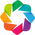

In [206]:
from matplotlib import pyplot as plt
import seaborn as sns

import hvplot.pandas
import holoviews as hv

hv.extension("bokeh")
%matplotlib inline

In [218]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [208]:
meanmape_census_gdf.crs

<Projected CRS: EPSG:3734>
Name: NAD83 / Ohio North (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - Ohio - SPCS - N
- bounds: (-84.81, 40.1, -80.51, 42.33)
Coordinate Operation:
- name: SPCS83 Ohio North zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [209]:
mapecensus = meanmape_census_gdf.to_crs('epsg:3857')

In [210]:
mapecensus.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [211]:
median_errors = census_trac.merge(
    salesTest.groupby("GEOID10")["percent_error"].median().reset_index(), on="GEOID10"
)

C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\site-packages\ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


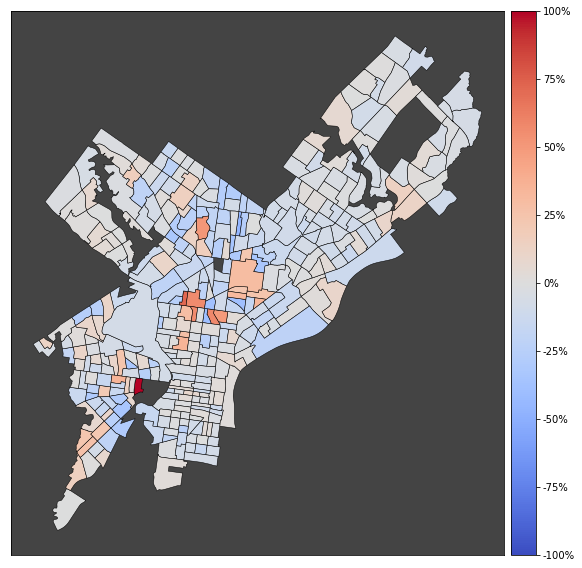

In [219]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Setup the colorbar axes
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Plot
median_errors.to_crs(epsg=2272).plot(
    ax=ax, column="percent_error", vmin=-100, vmax=100, legend=True, cax=cax, cmap='coolwarm', edgecolor='k', linewidth=0.5
)

# Format
ax.set_facecolor("#444444")
ax.set_xticks([])
ax.set_yticks([])
cax.set_yticklabels([f"{x:.0f}%" for x in cax.get_yticks()]);

Text(0.5, 1.0, 'Median MAPE by census tract')

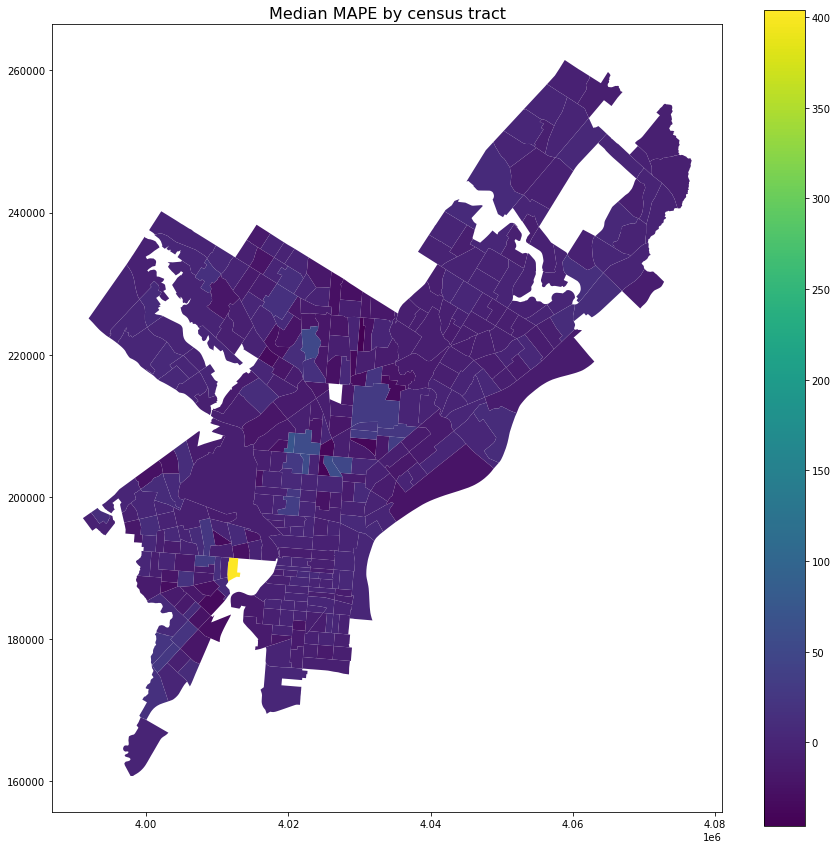

In [220]:
# create the axes
fig, ax = plt.subplots(figsize=(15, 15))

#Plot median income
median_errors.plot(ax=ax, column = 'percent_error', cmap = 'viridis', legend = True)
ax.set_title("Median MAPE by census tract", size = 16)

### 1.9 Compare the percent errors in Qualifying Census Tracts and other tracts 

[Qualifying Census Tracts](https://www.huduser.gov/portal/datasets/qct.html) are a poverty designation that HUD uses to allocate housing tax credits

In [221]:
qct = ['5',
 '20',
 '22',
 '28.01',
 '30.01',
 '30.02',
 '31',
 '32',
 '33',
 '36',
 '37.01',
 '37.02',
 '39.01',
 '41.01',
 '41.02',
 '56',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '69',
 '70',
 '71.01',
 '71.02',
 '72',
 '73',
 '74',
 '77',
 '78',
 '80',
 '81.01',
 '81.02',
 '82',
 '83.01',
 '83.02',
 '84',
 '85',
 '86.01',
 '86.02',
 '87.01',
 '87.02',
 '88.01',
 '88.02',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '98.01',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '119',
 '121',
 '122.01',
 '122.03',
 '131',
 '132',
 '137',
 '138',
 '139',
 '140',
 '141',
 '144',
 '145',
 '146',
 '147',
 '148',
 '149',
 '151.01',
 '151.02',
 '152',
 '153',
 '156',
 '157',
 '161',
 '162',
 '163',
 '164',
 '165',
 '167.01',
 '167.02',
 '168',
 '169.01',
 '169.02',
 '170',
 '171',
 '172.01',
 '172.02',
 '173',
 '174',
 '175',
 '176.01',
 '176.02',
 '177.01',
 '177.02',
 '178',
 '179',
 '180.02',
 '188',
 '190',
 '191',
 '192',
 '195.01',
 '195.02',
 '197',
 '198',
 '199',
 '200',
 '201.01',
 '201.02',
 '202',
 '203',
 '204',
 '205',
 '206',
 '208',
 '239',
 '240',
 '241',
 '242',
 '243',
 '244',
 '245',
 '246',
 '247',
 '249',
 '252',
 '253',
 '265',
 '267',
 '268',
 '271',
 '274.01',
 '274.02',
 '275',
 '276',
 '277',
 '278',
 '279.01',
 '279.02',
 '280',
 '281',
 '282',
 '283',
 '284',
 '285',
 '286',
 '287',
 '288',
 '289.01',
 '289.02',
 '290',
 '291',
 '293',
 '294',
 '298',
 '299',
 '300',
 '301',
 '302',
 '305.01',
 '305.02',
 '309',
 '311.01',
 '312',
 '313',
 '314.01',
 '314.02',
 '316',
 '318',
 '319',
 '321',
 '325',
 '329',
 '330',
 '337.01',
 '345.01',
 '357.01',
 '376',
 '377',
 '380',
 '381',
 '382',
 '383',
 '389',
 '390']

In [227]:
median_errors['qct'] = False
median_errors.loc[median_errors['NAME10'].isin(qct), 'qct'] = True

In [228]:
median_errors.groupby("qct")['percent_error'].median()

qct
False   -3.667065
Name: percent_error, dtype: float64